In [1]:
import pandas as pd
import numpy as np
import random

In [2]:
LOCATION = '../input/harvard-atlas-schizophrenia/'

In [3]:
participants = pd.read_csv(LOCATION + 'participants.csv')
control = participants[participants['diagnosis'] == 'Control']['id'].to_list()
schizophrenic = participants[participants['diagnosis'] != 'Control']['id'].to_list()

len(control), len(schizophrenic)

(206, 130)

In [4]:
tr = int(len(control) * 0.8)
va = tr + int(len(control) * 0.1)

train_list = control[:tr]
valid_list = control[tr:va]
test_list = control[va:]

tr = int(len(schizophrenic) * 0.8)
va = tr + int(len(schizophrenic) * 0.1)

train_list = train_list + schizophrenic[:tr]
valid_list = valid_list + schizophrenic[tr:va]
test_list = test_list + schizophrenic[va:]

random.shuffle(train_list)
random.shuffle(valid_list)
random.shuffle(test_list)

len(train_list), len(valid_list), len(test_list)

(268, 33, 35)

In [5]:
train_x, train_y = np.empty((0, 9216)), np.empty(0, int)
test_x, test_y = np.empty((0, 9216)), np.empty(0, int)
valid_x, valid_y = np.empty((0, 9216)), np.empty(0, int)

In [6]:
for train in train_list:
    diagnosis = participants[participants['id'] == train].iloc[0].diagnosis
    path = LOCATION + 'connectome/' + diagnosis + '/sub-'+train+'.npz'
        
    x = np.load(path)['arr_0'].reshape(-1)
    y = 0 if diagnosis == 'Control' else 1

    train_x = np.append(train_x, [x], axis=0)
    train_y = np.append(train_y, [y], axis=0)
    
train_x.shape, train_y.shape

((268, 9216), (268,))

In [7]:
for valid in valid_list:
    diagnosis = participants[participants['id'] == valid].iloc[0].diagnosis
    path = LOCATION + 'connectome/' + diagnosis + '/sub-'+valid+'.npz'
        
    x = np.load(path)['arr_0'].reshape(-1)
    y = 0 if diagnosis == 'Control' else 1

    valid_x = np.append(valid_x, [x], axis=0)
    valid_y = np.append(valid_y, [y], axis=0)
    
valid_x.shape, valid_y.shape

((33, 9216), (33,))

In [8]:
for test in test_list:
    diagnosis = participants[participants['id'] == test].iloc[0].diagnosis
    path = LOCATION + 'connectome/' + diagnosis + '/sub-'+test+'.npz'
        
    x = np.load(path)['arr_0'].reshape(-1)
    y = 0 if diagnosis == 'Control' else 1

    test_x = np.append(test_x, [x], axis=0)
    test_y = np.append(test_y, [y], axis=0)
    
test_x.shape, test_y.shape

((35, 9216), (35,))

In [9]:
import tensorflow as tf
from tensorflow import keras

In [10]:
stacked_encoder = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(9216,)),
    keras.layers.Dense(4096, activation = 'selu'),
    keras.layers.Dense(2048, activation = 'selu'),
    keras.layers.Dense(1024, activation = 'selu'),
    keras.layers.ActivityRegularization(l1=1e-3)
])

stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(2048, activation = 'selu', input_shape = (1024, )),
    keras.layers.Dense(4096, activation = 'selu'),
    keras.layers.Dense(9216, activation = 'sigmoid'),
])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.SGD(lr=.1))

history  =  stacked_ae.fit(train_x, train_x, epochs = 30, validation_data = (valid_x, valid_x))

2022-04-06 15:21:37.513363: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-06 15:21:37.522669: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-06 15:21:37.523404: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-06 15:21:37.524511: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/30
9/9 [==============================] - 1s 29ms/step - loss: 1.3569 - val_loss: 1.3589
Epoch 2/30
9/9 [==============================] - 0s 11ms/step - loss: 1.3095 - val_loss: 1.2777
Epoch 3/30
9/9 [==============================] - 0s 11ms/step - loss: 1.2955 - val_loss: 1.2427
Epoch 4/30
9/9 [==============================] - 0s 12ms/step - loss: 1.2976 - val_loss: 1.1799
Epoch 5/30
9/9 [==============================] - 0s 10ms/step - loss: 1.2680 - val_loss: 1.2155
Epoch 6/30
9/9 [==============================] - 0s 11ms/step - loss: 1.2568 - val_loss: 1.2906
Epoch 7/30
9/9 [==============================] - 0s 10ms/step - loss: 1.2560 - val_loss: 1.2474
Epoch 8/30
9/9 [==============================] - 0s 10ms/step - loss: 1.2468 - val_loss: 1.2255
Epoch 9/30
9/9 [==============================] - 0s 10ms/step - loss: 1.2471 - val_loss: 1.2990
Epoch 10/30
9/9 [==============================] - 0s 10ms/step - loss: 1.2446 - val_loss: 1.2156
Epoch 11/30
9/9 [============

In [11]:
encoded_train_x = np.empty((0, 1024))
encoded_test_x = np.empty((0, 1024))
encoded_valid_x = np.empty((0, 1024))

for i in range(train_x.shape[0]):
    encoded_train_x = np.append(encoded_train_x,
                                stacked_encoder.predict(np.expand_dims(train_x[i], axis=0)),
                                axis=0)
               
for i in range(valid_x.shape[0]):
    encoded_valid_x = np.append(encoded_valid_x,
                                stacked_encoder.predict(np.expand_dims(valid_x[i], axis=0)),
                                axis=0)
               
for i in range(test_x.shape[0]):
    encoded_test_x = np.append(encoded_test_x,
                                stacked_encoder.predict(np.expand_dims(test_x[i], axis=0)),
                                axis=0)
    
encoded_train_x.shape, encoded_valid_x.shape, encoded_test_x.shape

((268, 1024), (33, 1024), (35, 1024))

In [26]:
model = keras.models.Sequential()

model.add(keras.layers.InputLayer(input_shape=(1024,)))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(.2))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)               

In [27]:
train_loader = tf.data.Dataset.from_tensor_slices((encoded_train_x, train_y))
validation_loader = tf.data.Dataset.from_tensor_slices((encoded_valid_x, valid_y))

batch_size = 32
train_dataset = (train_loader.shuffle(len(encoded_train_x))
                 .batch(batch_size))

validation_dataset = (validation_loader.shuffle(len(encoded_valid_x))
                      .batch(batch_size))

In [28]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])


checkpoint_cb = keras.callbacks.ModelCheckpoint('connectome_classification.h5',
                                                save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_acc', patience=15)

In [29]:
%%time

epochs = 14
model.fit(train_dataset,
          validation_data=validation_dataset,
          epochs=epochs,
          shuffle=True,
          verbose=2,
          callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/14
9/9 - 1s - loss: 0.7124 - acc: 0.5672 - val_loss: 0.6452 - val_acc: 0.6061
Epoch 2/14
9/9 - 0s - loss: 0.7325 - acc: 0.5261 - val_loss: 0.6561 - val_acc: 0.6061
Epoch 3/14
9/9 - 0s - loss: 0.6847 - acc: 0.6269 - val_loss: 0.6759 - val_acc: 0.6061
Epoch 4/14
9/9 - 0s - loss: 0.6917 - acc: 0.5410 - val_loss: 0.6541 - val_acc: 0.6061
Epoch 5/14
9/9 - 0s - loss: 0.7030 - acc: 0.5672 - val_loss: 0.6494 - val_acc: 0.6061
Epoch 6/14
9/9 - 0s - loss: 0.6763 - acc: 0.5933 - val_loss: 0.6533 - val_acc: 0.6061
Epoch 7/14
9/9 - 0s - loss: 0.6876 - acc: 0.5933 - val_loss: 0.6590 - val_acc: 0.6061
Epoch 8/14
9/9 - 0s - loss: 0.6515 - acc: 0.6194 - val_loss: 0.6533 - val_acc: 0.6061
Epoch 9/14
9/9 - 0s - loss: 0.6807 - acc: 0.5933 - val_loss: 0.6539 - val_acc: 0.6061
Epoch 10/14
9/9 - 0s - loss: 0.6445 - acc: 0.6082 - val_loss: 0.6509 - val_acc: 0.6061
Epoch 11/14
9/9 - 0s - loss: 0.6698 - acc: 0.5821 - val_loss: 0.6576 - val_acc: 0.6061
Epoch 12/14
9/9 - 0s - loss: 0.6514 - acc: 0.6082 - 

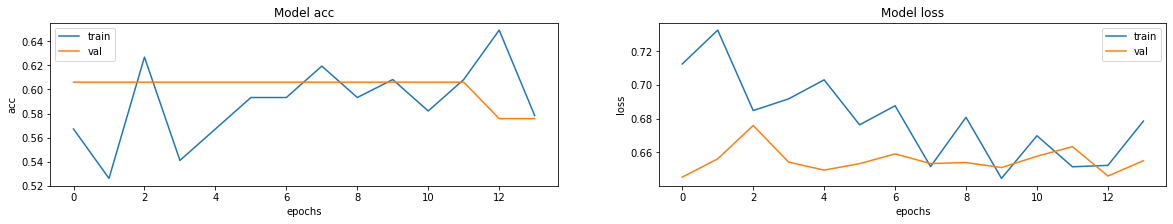

In [30]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [31]:
def get_probs(data):
    y = np.empty(0)
    
    for i in range(data.shape[0]):
        pred = model.predict(np.expand_dims(data[i], axis=0))
        y = np.append(y, pred[0], axis=0)
        
    return y

def get_predictions(data, threshold=0.5):
    y = get_probs(data)
    return np.where(y > threshold, 1, 0).astype(int)

In [40]:
from sklearn import metrics

pred_y = get_predictions(encoded_train_x, 0.44)
print("Accuracy:", metrics.accuracy_score(train_y, pred_y))
print("Confusion: \n", metrics.confusion_matrix(train_y, pred_y))
print(metrics.classification_report(train_y, pred_y))

Accuracy: 0.753731343283582
Confusion: 
 [[137  27]
 [ 39  65]]
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       164
           1       0.71      0.62      0.66       104

    accuracy                           0.75       268
   macro avg       0.74      0.73      0.73       268
weighted avg       0.75      0.75      0.75       268



In [41]:
pred_y = get_predictions(encoded_valid_x, 0.44)
print("Accuracy:", metrics.accuracy_score(valid_y, pred_y))
print("Confusion:\n", metrics.confusion_matrix(valid_y, pred_y))
print(metrics.classification_report(valid_y, pred_y))

Accuracy: 0.6363636363636364
Confusion:
 [[11  9]
 [ 3 10]]
              precision    recall  f1-score   support

           0       0.79      0.55      0.65        20
           1       0.53      0.77      0.62        13

    accuracy                           0.64        33
   macro avg       0.66      0.66      0.64        33
weighted avg       0.68      0.64      0.64        33



In [42]:
pred_y = get_predictions(encoded_test_x, 0.44)
print("Accuracy:", metrics.accuracy_score(test_y, pred_y))
print("Confusion:\n", metrics.confusion_matrix(test_y, pred_y))
print(metrics.classification_report(test_y, pred_y))

Accuracy: 0.7142857142857143
Confusion:
 [[17  5]
 [ 5  8]]
              precision    recall  f1-score   support

           0       0.77      0.77      0.77        22
           1       0.62      0.62      0.62        13

    accuracy                           0.71        35
   macro avg       0.69      0.69      0.69        35
weighted avg       0.71      0.71      0.71        35

